<a href="https://colab.research.google.com/github/LaZzyMan/Notebook/blob/master/multi_gcn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [259]:
import pandas as pd
import os
import pickle

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN, SqueezedSparseConversion, GraphConvolution, GraphPreProcessingLayer, GatherIndices

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from tensorflow.keras import backend as K
from sklearn import model_selection
from sklearn.preprocessing import LabelBinarizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import Sequence
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import ParameterGrid
from joblib import Parallel, delayed
import numpy as np
from tqdm import tqdm
import shap

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.sans-serif'] = 'SimHei'
sns.set(style='darkgrid')
sns.set_context('talk')

In [ ]:
!pip install geopandas stellargraph shap

In [212]:
graph_traffic, graph_spatial, graph_ts = pickle.load(open('/content/drive/My Drive/Data/sg_graphs_undirected_20151201_land_cover_poi_30.pickle', 'rb'))
labels = pickle.load(open('/content/drive/My Drive/Data/label_100.pickle', 'rb'))
num_nodes = len(labels)
X = []
Y = []
for node, label in labels.items():
    X.append(node)
    Y.append(label)
labels = pd.Series(Y, index=X)
gdf = pickle.load(open('/content/drive/My Drive/Data/land_use_unit_display.pickle', 'rb'))

In [ ]:
graph_traffic_lp, graph_spatial_lp, graph_ts_lp = pickle.load(open('/content/drive/My Drive/Data/graphs/sg_graphs_undirected_20151201_land_cover_poi_30.pickle', 'rb'))
graph_traffic_l, graph_spatial_l, graph_ts_l = pickle.load(open('/content/drive/My Drive/Data/graphs/sg_graphs_undirected_20151201_land_cover_30.pickle', 'rb'))
graph_traffic_p, graph_spatial_p, graph_ts_p = pickle.load(open('/content/drive/My Drive/Data/graphs/sg_graphs_undirected_20151201_poi_30.pickle', 'rb'))
graph_traffic_n, graph_spatial_n, graph_ts_n = pickle.load(open('/content/drive/My Drive/Data/graphs/sg_graphs_undirected_20151201_none_30.pickle', 'rb'))

# GCN

In [ ]:
class AggregateSequence(Sequence):
    def __init__(self, sequences):
        # 整合多个网络的输入batch
        self.sequences = sequences
        self.len = self.sequences[0].__len__()

    def __len__(self):
        return self.len

    def __getitem__(self, item):
        x_agg = []
        y_agg = None
        for seq in self.sequences:
            x, y = seq.__getitem__(item)
            y_agg = y
            for inp in x:
                x_agg.append(inp)
        return x_agg, y_agg

In [ ]:
tr_farc = .2
val_frac = .4
# 分层抽样分割训练集和测试集
train_set, test_set = model_selection.train_test_split(
    labels, train_size=int(num_nodes * tr_farc), test_size=None, stratify=labels
)
# 将测试集分割份被用于验证和评价测试
val_set, test_set = model_selection.train_test_split(
    test_set, train_size=int(num_nodes * val_frac), test_size=None, stratify=test_set
)
# 将标签转为二进制编码
bin_encoding = LabelBinarizer()
train_Y = bin_encoding.fit_transform(train_set)
val_Y = bin_encoding.transform(val_set)
test_Y = bin_encoding.transform(test_set)

In [ ]:
# 生成网络的full batch输入
generator_traffic = FullBatchNodeGenerator(graph_traffic, method="gcn")
generator_spatial = FullBatchNodeGenerator(graph_spatial, method="gcn")
generator_ts = FullBatchNodeGenerator(graph_ts, method="gcn")
train_gen_traffic = generator_traffic.flow(train_set.index, train_Y)
train_gen_spatial = generator_spatial.flow(train_set.index, train_Y)
train_gen_ts = generator_ts.flow(train_set.index, train_Y)
agg_train_gen = AggregateSequence([train_gen_traffic, train_gen_spatial, train_gen_ts])
# GCN聚合层
gcn_traffic = GCN(layer_sizes=[200, 128], activations=["relu", "relu"], generator=generator_traffic, dropout=0.3)
gcn_spatial = GCN(layer_sizes=[200, 128], activations=["relu", "relu"], generator=generator_spatial, dropout=0.3)
gcn_ts = GCN(layer_sizes=[200, 128], activations=["relu", "relu"], generator=generator_ts, dropout=0.3)
x_in_traffic, x_out_traffic = gcn_traffic.in_out_tensors()
x_in_spatial, x_out_spatial = gcn_spatial.in_out_tensors()
x_in_ts, x_out_ts = gcn_ts.in_out_tensors()
# 多抽头合并
x_out = layers.Lambda(lambda x: K.relu(x / 3))(layers.add([x_out_traffic, x_out_spatial, x_out_ts]))
# softmax多分类预测
predictions = layers.Dense(units=train_Y.shape[1], activation="softmax")(x_out)
model = Model(inputs=x_in_traffic + x_in_spatial + x_in_ts, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)
# 验证数据集用于计算损失函数
val_gen_traffic = generator_traffic.flow(val_set.index, val_Y)
val_gen_spatial = generator_spatial.flow(val_set.index, val_Y)
val_gen_ts = generator_ts.flow(val_set.index, val_Y)
agg_val_gen = AggregateSequence([val_gen_traffic, val_gen_spatial, val_gen_ts])

# 设置提前停止条件
es_callback = EarlyStopping(monitor="val_acc", patience=100, restore_best_weights=True)

Using GCN (local pooling) filters...
Using GCN (local pooling) filters...
Using GCN (local pooling) filters...


In [ ]:
history = model.fit(
    agg_train_gen,
    epochs=1000,
    validation_data=agg_val_gen,
    verbose=2,
    shuffle=False,
    callbacks=[es_callback],
)

Epoch 1/1000
1/1 - 0s - loss: 1.8159 - acc: 0.1086 - val_loss: 1.6859 - val_acc: 0.3317
Epoch 2/1000
1/1 - 0s - loss: 1.6872 - acc: 0.3322 - val_loss: 1.6119 - val_acc: 0.3908
Epoch 3/1000
1/1 - 0s - loss: 1.6138 - acc: 0.3914 - val_loss: 1.6132 - val_acc: 0.3892
Epoch 4/1000
1/1 - 0s - loss: 1.6155 - acc: 0.4013 - val_loss: 1.6123 - val_acc: 0.4778
Epoch 5/1000
1/1 - 0s - loss: 1.6146 - acc: 0.4803 - val_loss: 1.5833 - val_acc: 0.4959
Epoch 6/1000
1/1 - 0s - loss: 1.5774 - acc: 0.5164 - val_loss: 1.5598 - val_acc: 0.4581
Epoch 7/1000
1/1 - 0s - loss: 1.5520 - acc: 0.4704 - val_loss: 1.5447 - val_acc: 0.4072
Epoch 8/1000
1/1 - 0s - loss: 1.5357 - acc: 0.4276 - val_loss: 1.5276 - val_acc: 0.4039
Epoch 9/1000
1/1 - 0s - loss: 1.5194 - acc: 0.4342 - val_loss: 1.5020 - val_acc: 0.4286
Epoch 10/1000
1/1 - 0s - loss: 1.4889 - acc: 0.4507 - val_loss: 1.4704 - val_acc: 0.4696
Epoch 11/1000
1/1 - 0s - loss: 1.4596 - acc: 0.5033 - val_loss: 1.4404 - val_acc: 0.5172
Epoch 12/1000
1/1 - 0s - loss:

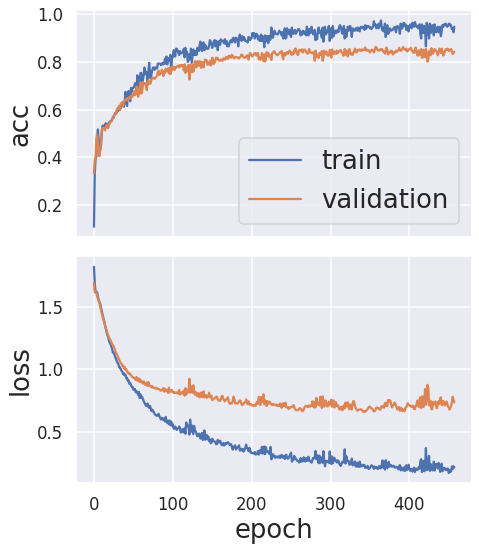

In [ ]:
sg.utils.plot_history(history)

In [ ]:
# 计算在测试集上的准确度
test_gen_traffic = generator_traffic.flow(test_set.index, test_Y)
test_gen_saptial = generator_spatial.flow(test_set.index, test_Y)
test_gen_ts = generator_ts.flow(test_set.index, test_Y)
agg_test_gen = AggregateSequence([test_gen_traffic, test_gen_saptial, test_gen_ts])
test_metrics = model.evaluate(agg_test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
  print("{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 1ms/step - loss: 0.8255 - acc: 0.8380

Test Set Metrics:
loss: 0.8255
acc: 0.8380


In [ ]:
# 计算整个分类的结果
all_nodes = labels.index
all_gen_traffic = generator_traffic.flow(all_nodes)
all_gen_spatial = generator_spatial.flow(all_nodes)
all_gen_ts = generator_ts.flow(all_nodes)
all_gen = AggregateSequence([all_gen_traffic, all_gen_spatial, all_gen_ts])
all_predictions = model.predict(all_gen)
node_predictions = bin_encoding.inverse_transform(all_predictions.squeeze())
df = pd.DataFrame({"Predicted": node_predictions, "True": labels})

Y = bin_encoding.fit_transform(labels)
Y_ = bin_encoding.fit_transform(node_predictions)
averages = ["micro", "macro"]
overall_result = {}
for average in averages:
  overall_result[average] = f1_score(Y, Y_, average=average)
overall_result['acc'] = accuracy_score(Y, Y_)
single_result = classification_report(labels, node_predictions, target_names=bin_encoding.classes_, output_dict=True)
single_result = pd.DataFrame.from_dict(single_result)
cm = confusion_matrix(labels, node_predictions, labels=bin_encoding.classes_)
print('Overall Result: \n')
print(overall_result)

Overall Result: 

{'micro': 0.8727034120734908, 'macro': 0.814991062941242, 'acc': 0.8727034120734908}


In [ ]:
# 各类别分类结果评价
single_result

,C,G,M,P,R,U,accuracy,macro avg,weighted avg
precision,0.868009,0.736842,0.842697,0.748954,0.958250,0.925926,0.872703,0.846780,0.871580
recall,0.977330,0.500000,0.862069,0.781659,0.952569,0.707547,0.872703,0.796862,0.872703
f1-score,0.919431,0.595745,0.852273,0.764957,0.955401,0.802139,0.872703,0.814991,0.868549
support,397.000000,112.000000,174.000000,229.000000,506.000000,106.000000,0.872703,1524.000000,1524.000000


Text(62.7, 0.5, 'TRUE')

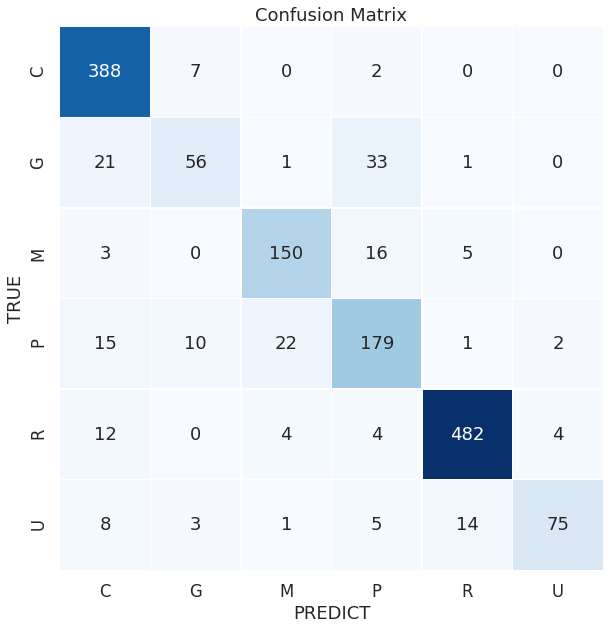

In [ ]:
# 混淆矩阵
classes = ['C', 'G', 'M', 'P', 'R', 'U']
_, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, xticklabels=classes, yticklabels=classes, fmt='.20g', square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title('Confusion Matrix')
ax.set_xlabel('PREDICT')
ax.set_ylabel('TRUE') 

In [ ]:
# 获取embedding并通过PCA转为2维向量
embedding_model = Model(inputs=x_in_traffic + x_in_spatial + x_in_ts, outputs=x_out)
emb = embedding_model.predict(all_gen)
emb = emb.squeeze(0)
tsne = TSNE(n_components=2,init='pca',verbose=1)
emb_tsne = tsne.fit_transform(emb)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1524 samples in 0.015s...
[t-SNE] Computed neighbors for 1524 samples in 0.298s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1524
[t-SNE] Computed conditional probabilities for sample 1524 / 1524
[t-SNE] Mean sigma: 1.016418
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.104401
[t-SNE] KL divergence after 1000 iterations: 0.679030


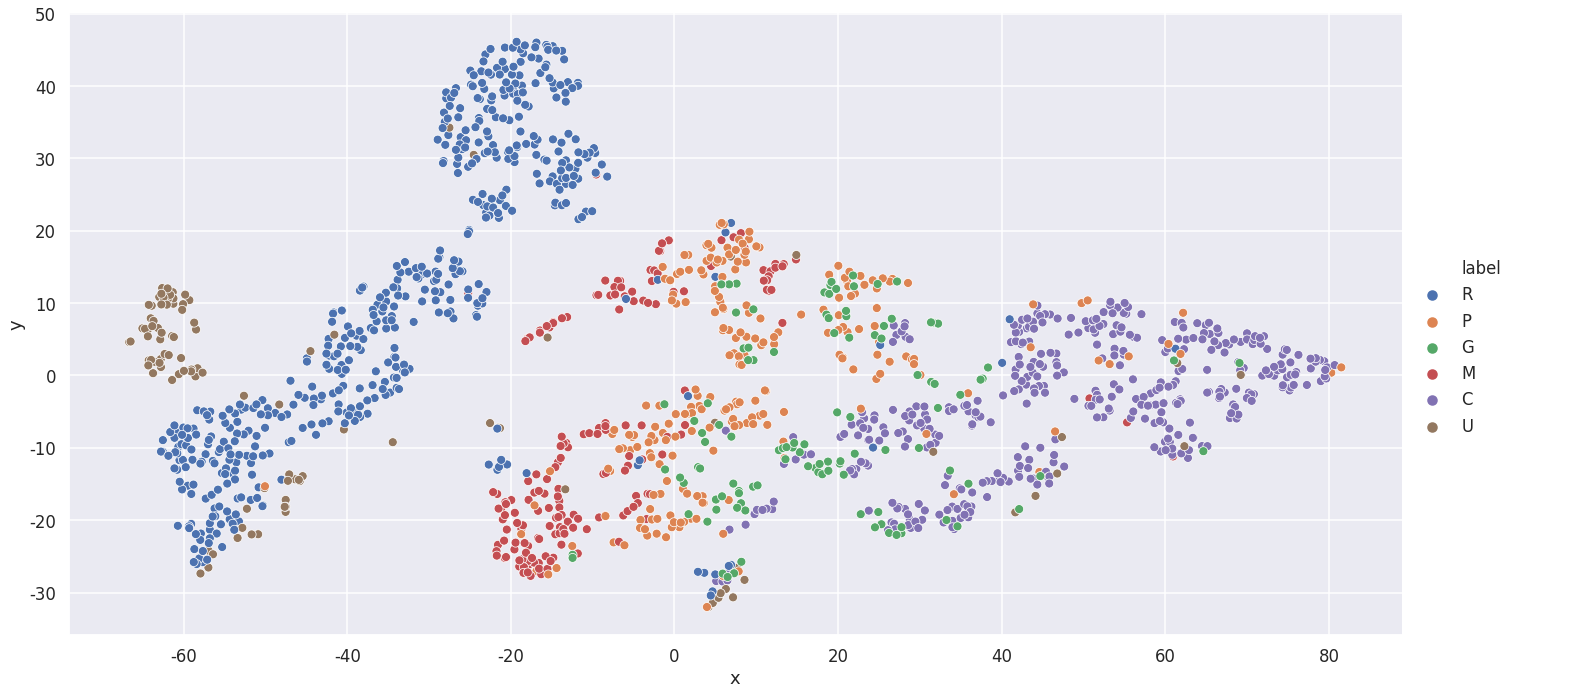

In [ ]:
# Node Embedding二维空间展示
tmp = pd.DataFrame(dict(x=emb_tsne[:, 0], y=emb_tsne[:, 1], label=labels.tolist()))
sns.relplot(x='x', y='y', hue='label', data=tmp, height=10, aspect=2)

# GCN Function

In [ ]:
def train_gcn(graphs=None, labels=None, layer_sizes=None, dropout=.3, lr=0.01, l2_reg=0.001):
    tr_farc = .2
    val_frac = .4
    # 分层抽样分割训练集和测试集
    train_set, test_set = model_selection.train_test_split(
        labels, train_size=int(num_nodes * tr_farc), test_size=None, stratify=labels
    )
    # 将测试集分割份被用于验证和评价测试
    val_set, test_set = model_selection.train_test_split(
        test_set, train_size=int(num_nodes * val_frac), test_size=None, stratify=test_set
    )
    # 将标签转为二进制编码
    bin_encoding = LabelBinarizer()
    train_Y = bin_encoding.fit_transform(train_set)
    val_Y = bin_encoding.transform(val_set)
    test_Y = bin_encoding.transform(test_set)
    # 生成网络的full batch输入
    generators = [FullBatchNodeGenerator(graph, method="gcn") for graph in graphs]
    train_gens = [generator.flow(train_set.index, train_Y) for generator in generators]
    agg_train_gen = AggregateSequence(train_gens)
    # GCN聚合层
    gcns = [GCN(layer_sizes=layer_sizes, activations=['relu'] * len(layer_sizes), generator=generator, dropout=dropout, kernel_regularizer=l2(l2_reg)) for generator in generators]
    x_ins = []
    x_outs = []
    for gcn in gcns:
        xin, xout = gcn.in_out_tensors()
        x_ins += xin
        x_outs.append(xout)
    # 多抽头合并
    x_out = layers.Lambda(lambda x: K.relu(x / 3))(layers.add(x_outs))
    # softmax多分类预测
    predictions = layers.Dense(units=train_Y.shape[1], activation="softmax")(x_out)
    model = Model(inputs=x_ins, outputs=predictions)
    model.compile(
        optimizer=optimizers.Adam(lr=lr),
        loss=losses.categorical_crossentropy,
        metrics=["acc"],
    )
    # 验证数据集用于计算损失函数
    val_gens = [generator.flow(val_set.index, val_Y) for generator in generators]
    agg_val_gen = AggregateSequence(val_gens)

    # 设置提前停止条件
    es_callback = EarlyStopping(monitor="val_acc", patience=100, restore_best_weights=True)
    history = model.fit(
        agg_train_gen,
        epochs=10000,
        validation_data=agg_val_gen,
        verbose=0,
        shuffle=False,
        callbacks=[es_callback],
    )
    
    # 计算整个分类的结果
    all_nodes = labels.index
    all_gens = [generator.flow(all_nodes) for generator in generators]
    all_gen = AggregateSequence(all_gens)
    all_predictions = model.predict(all_gen)
    node_predictions = bin_encoding.inverse_transform(all_predictions.squeeze())
    # df = pd.DataFrame({"Predicted": node_predictions, "True": labels})

    Y = bin_encoding.fit_transform(labels)
    Y_ = bin_encoding.fit_transform(node_predictions)
    averages = ['micro', 'macro', 'weighted']
    overall_result = {}
    for average in averages:
        overall_result[average] = f1_score(Y, Y_, average=average)
    overall_result['acc'] = accuracy_score(Y, Y_)
    single_result = classification_report(labels, node_predictions, target_names=bin_encoding.classes_,
                                          output_dict=True)
    single_result = pd.DataFrame.from_dict(single_result)
    cm = confusion_matrix(labels, node_predictions, labels=bin_encoding.classes_)
    # print('Overall Result: \n')
    # print(overall_result)
    return overall_result, single_result, cm

In [ ]:
result = train_gcn([graph_traffic, graph_spatial, graph_ts], labels, layer_sizes=[32, 32], dropout=.3, lr=0.001, l2_reg=0.0001)

Using GCN (local pooling) filters...
Using GCN (local pooling) filters...
Using GCN (local pooling) filters...
Epoch 1/1000
1/1 - 0s - loss: 1.8608 - acc: 0.1151 - val_loss: 1.8527 - val_acc: 0.1133
Epoch 2/1000
1/1 - 0s - loss: 1.8549 - acc: 0.1184 - val_loss: 1.8469 - val_acc: 0.1133
Epoch 3/1000
1/1 - 0s - loss: 1.8480 - acc: 0.1184 - val_loss: 1.8412 - val_acc: 0.1133
Epoch 4/1000
1/1 - 0s - loss: 1.8435 - acc: 0.1151 - val_loss: 1.8357 - val_acc: 0.1133
Epoch 5/1000
1/1 - 0s - loss: 1.8389 - acc: 0.1184 - val_loss: 1.8304 - val_acc: 0.1133
Epoch 6/1000
1/1 - 0s - loss: 1.8323 - acc: 0.1151 - val_loss: 1.8252 - val_acc: 0.1133
Epoch 7/1000
1/1 - 0s - loss: 1.8279 - acc: 0.1151 - val_loss: 1.8203 - val_acc: 0.1133
Epoch 8/1000
1/1 - 0s - loss: 1.8230 - acc: 0.1151 - val_loss: 1.8155 - val_acc: 0.1133
Epoch 9/1000
1/1 - 0s - loss: 1.8163 - acc: 0.1151 - val_loss: 1.8108 - val_acc: 0.1281
Epoch 10/1000
1/1 - 0s - loss: 1.8117 - acc: 0.1250 - val_loss: 1.8062 - val_acc: 0.2184
Epoch 11

In [ ]:
print(result[0])

{'micro': 0.76246719160105, 'macro': 0.6119514097975668, 'weighted': 0.7351678155268107, 'acc': 0.7624671916010499}


In [ ]:
result[1]

,C,G,M,P,R,U,accuracy,macro avg,weighted avg
precision,0.870670,0.538462,0.787709,0.697248,0.950495,0.905882,0.841864,0.791744,0.839678
recall,0.949622,0.500000,0.810345,0.663755,0.948617,0.726415,0.841864,0.766459,0.841864
f1-score,0.908434,0.518519,0.798867,0.680089,0.949555,0.806283,0.841864,0.776958,0.839505
support,397.000000,112.000000,174.000000,229.000000,506.000000,106.000000,0.841864,1524.000000,1524.000000


Text(62.7, 0.5, 'TRUE')

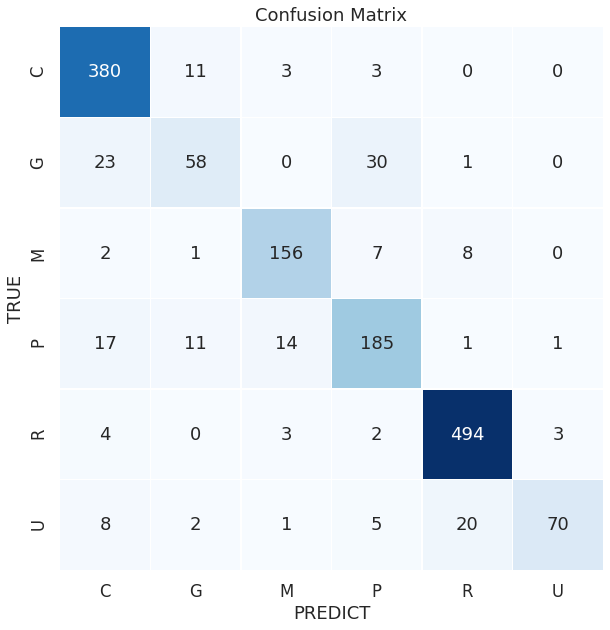

In [ ]:
# 混淆矩阵
cm = result[2]
classes = ['C', 'G', 'M', 'P', 'R', 'U']
_, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, xticklabels=classes, yticklabels=classes, fmt='.20g', square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title('Confusion Matrix')
ax.set_xlabel('PREDICT')
ax.set_ylabel('TRUE')

In [ ]:
# 网格搜索
def fit_with_param(param):
  overall, _, _ = train_gcn([graph_traffic, graph_spatial, graph_ts], labels, layer_sizes=param['layer_sizes'], dropout=param['dropout'], lr=param['lr'], l2_reg=param['l2_reg'])
  result = {'params':param, 'score': overall}
  print(result)
  return result
param_dist = {'lr': [0.001, 0.003, 0.005, 0.007, 0.009, 0.01],
        'l2_reg': [0.0001, 0.0003, 0.005, 0.0007, 0.0009, 0.001],
        'layer_sizes': [[32, 32], [64, 64], [128, 128]],
        'dropout': [.2, .3, .4, .5]}
param_grid = ParameterGrid(param_dist)
for param in tqdm(param_grid):
  fit_with_param(param)

# 多通道GCN


In [ ]:
class AggregateSequence(Sequence):
    def __init__(self, sequences):
        # 整合多个网络的输入batch
        self.sequences = sequences
        self.len = self.sequences[0].__len__()

    def __len__(self):
        return self.len

    def __getitem__(self, item):
        x_agg = []
        y_agg = None
        x_agg += self.sequences[0].__getitem__(item)[0][:2]
        for seq in self.sequences:
            x, y = seq.__getitem__(item)
            y_agg = y
            x_agg.append(x[2:])
        return x_agg, y_agg

In [247]:
layer_sizes = [64, 64]
dropout = .3
l2_reg = 0.0001
lr = 0.002
verbose = 2
graphs = [graph_traffic_lp, graph_spatial_lp, graph_ts_lp]

tr_farc = .2
val_frac = .4
# 分层抽样分割训练集和测试集
train_set, test_set = model_selection.train_test_split(
    labels, train_size=int(num_nodes * tr_farc), test_size=None, stratify=labels
)
# 将测试集分割份被用于验证和评价测试
val_set, test_set = model_selection.train_test_split(
    test_set, train_size=int(num_nodes * val_frac), test_size=None, stratify=test_set
)
# 将标签转为二进制编码
bin_encoding = LabelBinarizer()
train_Y = bin_encoding.fit_transform(train_set)
val_Y = bin_encoding.transform(val_set)
test_Y = bin_encoding.transform(test_set)
# 生成网络的full batch Sequence
generators = [FullBatchNodeGenerator(graph, method="gcn") for graph in graphs]
n_nodes = generators[0].features.shape[0]
n_features = generators[0].features.shape[1]
# 网络输入[features, indices, [adj_indices, adj_values] * n]
features = layers.Input(batch_shape=(1, n_nodes, n_features), name='features')
out_indices = layers.Input(batch_shape=(1, None), dtype="int32", name='out_indices')
adj_place_holders = []
x_input = [features, out_indices]
for i in range(len(graphs)):
    adj_indices = layers.Input(batch_shape=(1, None, 2), dtype="int64", name='adj_indices_%d' % i)
    adj_values = layers.Input(batch_shape=(1, None), name='adj_values_%d' % i)
    adj_place_holders.append([adj_indices, adj_values])
    x_input += [adj_indices, adj_values]
adj_inputs = [SqueezedSparseConversion(shape=(n_nodes, n_nodes), dtype=placeholder[1].dtype)(placeholder) for placeholder in adj_place_holders]

# 多通道图卷积
x_outs = layers.Dropout(dropout)(features)
if len(layer_sizes) > 1:
    for layer_size in layer_sizes[: -1]:
        x_outs = [GraphConvolution(layer_size, 'relu', kernel_regularizer=l2(l2_reg))([x_outs, adj_input]) for adj_input in adj_inputs]
        x_outs = layers.Dropout(dropout)(layers.concatenate(x_outs))
    x_outs = [GraphConvolution(layer_sizes[-1], 'relu', kernel_regularizer=l2(l2_reg))([x_outs, adj_input]) for adj_input in adj_inputs]
    x_out = layers.Lambda(lambda x: K.relu(x / 3))(layers.add(x_outs))
else:
    x_outs = [GraphConvolution(layer_sizes[0], 'relu', kernel_regularizer=l2(l2_reg))([x_outs, adj_input]) for adj_input in adj_inputs]
    x_out = layers.Lambda(lambda x: K.relu(x / 3))(layers.add(x_outs))

# softmax多分类预测
x_out = GatherIndices(batch_dims=1)([x_out, out_indices])
# x_out = layers.Lambda(lambda x: K.squeeze(x, 0))(x_out)
predictions = layers.Dense(units=train_Y.shape[1], activation="softmax")(x_out)
model = Model(inputs=x_input, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=lr),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)
# 生成训练集输入Sequence
train_gens = [generator.flow(train_set.index, train_Y) for generator in generators]
agg_train_gen = AggregateSequence(train_gens)
# 验证数据集Sequence用于计算损失函数
val_gens = [generator.flow(val_set.index, val_Y) for generator in generators]
agg_val_gen = AggregateSequence(val_gens)

# 设置提前停止条件
es_callback = EarlyStopping(monitor="val_acc", patience=500, restore_best_weights=True)

Using GCN (local pooling) filters...
Using GCN (local pooling) filters...
Using GCN (local pooling) filters...


In [248]:
history = model.fit(
    agg_train_gen,
    epochs=10000,
    validation_data=agg_val_gen,
    verbose=verbose,
    shuffle=False,
    callbacks=[es_callback],
)

Epoch 1/10000
1/1 - 0s - loss: 1.8629 - acc: 0.1184 - val_loss: 1.8225 - val_acc: 0.3317
Epoch 2/10000
1/1 - 0s - loss: 1.8227 - acc: 0.3257 - val_loss: 1.7872 - val_acc: 0.3317
Epoch 3/10000
1/1 - 0s - loss: 1.7857 - acc: 0.3322 - val_loss: 1.7566 - val_acc: 0.3317
Epoch 4/10000
1/1 - 0s - loss: 1.7550 - acc: 0.3322 - val_loss: 1.7298 - val_acc: 0.3399
Epoch 5/10000
1/1 - 0s - loss: 1.7283 - acc: 0.3421 - val_loss: 1.7068 - val_acc: 0.3777
Epoch 6/10000
1/1 - 0s - loss: 1.7059 - acc: 0.3520 - val_loss: 1.6868 - val_acc: 0.4122
Epoch 7/10000
1/1 - 0s - loss: 1.6852 - acc: 0.3947 - val_loss: 1.6692 - val_acc: 0.4368
Epoch 8/10000
1/1 - 0s - loss: 1.6677 - acc: 0.4145 - val_loss: 1.6541 - val_acc: 0.4565
Epoch 9/10000
1/1 - 0s - loss: 1.6550 - acc: 0.4441 - val_loss: 1.6417 - val_acc: 0.4729
Epoch 10/10000
1/1 - 0s - loss: 1.6406 - acc: 0.4671 - val_loss: 1.6313 - val_acc: 0.4893
Epoch 11/10000
1/1 - 0s - loss: 1.6302 - acc: 0.4836 - val_loss: 1.6223 - val_acc: 0.5041
Epoch 12/10000
1/1 

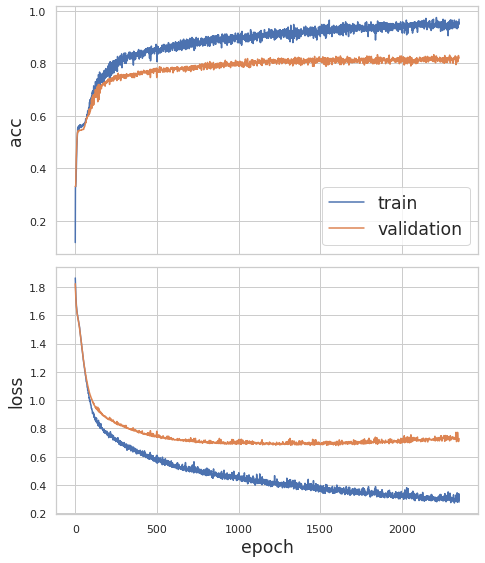

In [249]:
sg.utils.plot_history(history)

In [250]:
# 计算在测试集上的准确度
test_gens = [generator.flow(test_set.index, test_Y) for generator in generators]
agg_test_gen = AggregateSequence(test_gens)
test_metrics = model.evaluate(agg_test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
  print("{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 1ms/step - loss: 0.6317 - acc: 0.8511

Test Set Metrics:
loss: 0.6317
acc: 0.8511


In [251]:
# 计算整个分类的结果
all_nodes = labels.index
all_gens = [generator.flow(all_nodes) for generator in generators]
all_gen = AggregateSequence(all_gens)
all_predictions = model.predict(all_gen)
node_predictions = bin_encoding.inverse_transform(all_predictions.squeeze())

Y = bin_encoding.fit_transform(labels)
Y_ = bin_encoding.fit_transform(node_predictions)
averages = ["micro", "macro"]
overall_result = {}
for average in averages:
    overall_result[average] = f1_score(Y, Y_, average=average)
overall_result['acc'] = accuracy_score(Y, Y_)
single_result = classification_report(labels, node_predictions, target_names=bin_encoding.classes_, output_dict=True)
single_result = pd.DataFrame.from_dict(single_result)
cm = confusion_matrix(labels, node_predictions, labels=bin_encoding.classes_)
print(overall_result)

{'micro': 0.8648293963254594, 'macro': 0.7979789858173282, 'acc': 0.8648293963254593}


In [252]:
single_result

,C,G,M,P,R,U,accuracy,macro avg,weighted avg
precision,0.907143,0.642857,0.820225,0.740586,0.954455,0.795918,0.864829,0.810197,0.860742
recall,0.959698,0.482143,0.839080,0.772926,0.952569,0.735849,0.864829,0.790378,0.864829
f1-score,0.932681,0.551020,0.829545,0.756410,0.953511,0.764706,0.864829,0.797979,0.861603
support,397.000000,112.000000,174.000000,229.000000,506.000000,106.000000,0.864829,1524.000000,1524.000000


Text(73.7, 0.5, 'TRUE')

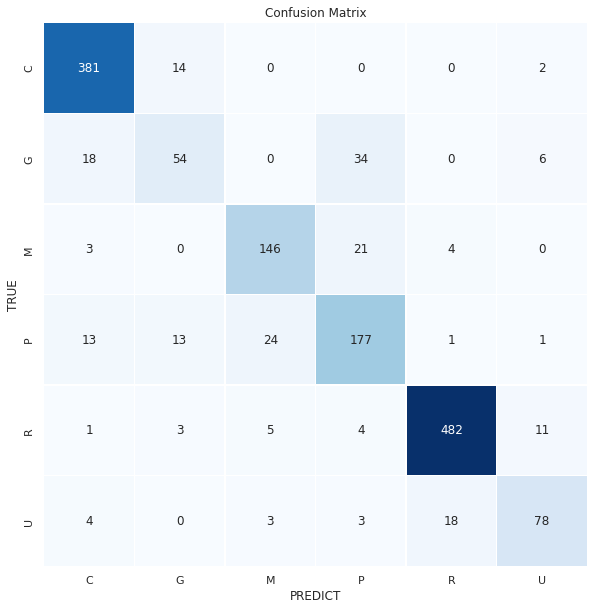

In [253]:
# 混淆矩阵
classes = ['C', 'G', 'M', 'P', 'R', 'U']
_, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, xticklabels=classes, yticklabels=classes, fmt='.20g', square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title('Confusion Matrix')
ax.set_xlabel('PREDICT')
ax.set_ylabel('TRUE') 

In [254]:
# 获取embedding并通过PCA转为2维向量
embedding_model = Model(inputs=x_input, outputs=x_out)
emb = embedding_model.predict(all_gen)
emb = emb.squeeze(0)
tsne = TSNE(n_components=2,init='pca',verbose=1)
emb_tsne = tsne.fit_transform(emb)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1524 samples in 0.008s...
[t-SNE] Computed neighbors for 1524 samples in 0.197s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1524
[t-SNE] Computed conditional probabilities for sample 1524 / 1524
[t-SNE] Mean sigma: 0.945098
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.677582
[t-SNE] KL divergence after 1000 iterations: 0.753562


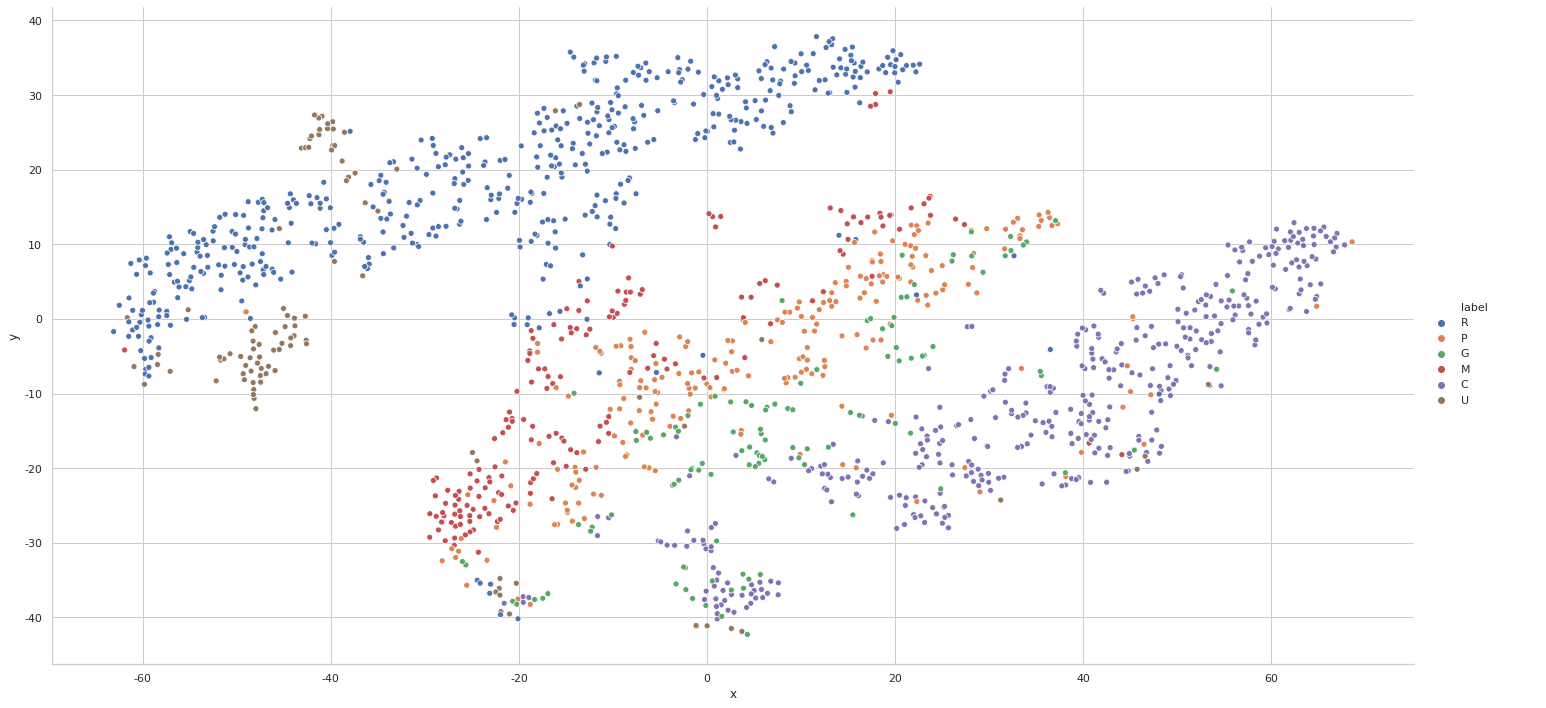

In [255]:
# Node Embedding二维空间展示
tmp = pd.DataFrame(dict(x=emb_tsne[:, 0], y=emb_tsne[:, 1], label=labels.tolist()))
sns.relplot(x='x', y='y', hue='label', data=tmp, height=10, aspect=2)

In [256]:
df = pd.DataFrame({"Predicted": [str(i) for i in node_predictions], "True": list(labels)}, index=[int(i) for i in list(labels.index)])
df['predicted_result'] = df.apply(lambda x: 1 if x['Predicted'] == x['True'] else 0, axis=1)
gdf['predicted'] = df['Predicted']
gdf['predicted_result'] = df['predicted_result']
gdf.to_file('/content/drive/My Drive/Data/export/classify_result.geojson', driver='GeoJSON')

# 多通道GCN Function



In [ ]:
class AggregateSequence(Sequence):
    def __init__(self, sequences):
        # 整合多个网络的输入batch
        self.sequences = sequences
        self.len = self.sequences[0].__len__()

    def __len__(self):
        return self.len

    def __getitem__(self, item):
        x_agg = []
        y_agg = None
        x_agg += self.sequences[0].__getitem__(item)[0][:2]
        for seq in self.sequences:
            x, y = seq.__getitem__(item)
            y_agg = y
            x_agg.append(x[2:])
        return x_agg, y_agg

In [ ]:
def train_multi_gcn(graphs=None, labels=None, layer_sizes=None, dropout=.3, lr=0.01, l2_reg=0.001, verbose=2):
    tr_farc = .2
    val_frac = .4
    # 分层抽样分割训练集和测试集
    train_set, test_set = model_selection.train_test_split(
        labels, train_size=int(num_nodes * tr_farc), test_size=None, stratify=labels
    )
    # 将测试集分割份被用于验证和评价测试
    val_set, test_set = model_selection.train_test_split(
        test_set, train_size=int(num_nodes * val_frac), test_size=None, stratify=test_set
    )
    # 将标签转为二进制编码
    bin_encoding = LabelBinarizer()
    train_Y = bin_encoding.fit_transform(train_set)
    val_Y = bin_encoding.transform(val_set)
    test_Y = bin_encoding.transform(test_set)
    # 生成网络的full batch Sequence
    generators = [FullBatchNodeGenerator(graph, method="gcn") for graph in graphs]
    n_nodes = generators[0].features.shape[0]
    n_features = generators[0].features.shape[1]
    # 网络输入[features, indices, [adj_indices, adj_values] * n]
    features = layers.Input(batch_shape=(1, n_nodes, n_features), name='features')
    out_indices = layers.Input(batch_shape=(1, None), dtype="int32", name='out_indices')
    adj_place_holders = []
    x_input = [features, out_indices]
    for i in range(len(graphs)):
        adj_indices = layers.Input(batch_shape=(1, None, 2), dtype="int64", name='adj_indices_%d' % i)
        adj_values = layers.Input(batch_shape=(1, None), name='adj_values_%d' % i)
        adj_place_holders.append([adj_indices, adj_values])
        x_input += [adj_indices, adj_values]
    # adj_inputs = [GraphPreProcessingLayer(num_of_nodes=n_nodes)(SqueezedSparseConversion(shape=(n_nodes, n_nodes), dtype=placeholder[1].dtype)(placeholder))
    #               for placeholder in adj_place_holders]
    adj_inputs = [SqueezedSparseConversion(shape=(n_nodes, n_nodes), dtype=placeholder[1].dtype)(placeholder) for placeholder in adj_place_holders]

    # 多通道图卷积
    x_outs = layers.Dropout(dropout)(features)
    if len(layer_sizes) > 1:
        for layer_size in layer_sizes[: -1]:
            x_outs = [GraphConvolution(layer_size, 'relu', kernel_regularizer=l2(l2_reg))([x_outs, adj_input]) for adj_input in adj_inputs]
            x_outs = layers.Dropout(dropout)(layers.concatenate(x_outs))
        x_outs = [GraphConvolution(layer_sizes[-1], 'relu', kernel_regularizer=l2(l2_reg))([x_outs, adj_input]) for adj_input in adj_inputs]
        x_out = layers.Lambda(lambda x: K.relu(x / 3))(layers.add(x_outs))
    else:
        x_outs = [GraphConvolution(layer_sizes[0], 'relu', kernel_regularizer=l2(l2_reg))([x_outs, adj_input]) for adj_input in adj_inputs]
        x_out = layers.Lambda(lambda x: K.relu(x / 3))(layers.add(x_outs))

    # softmax多分类预测
    x_out = GatherIndices(batch_dims=1)([x_out, out_indices])
    # x_out = layers.Lambda(lambda x: K.squeeze(x, 0))(x_out)
    predictions = layers.Dense(units=train_Y.shape[1], activation="softmax")(x_out)
    model = Model(inputs=x_input, outputs=predictions)
    model.compile(
        optimizer=optimizers.Adam(lr=lr),
        loss=losses.categorical_crossentropy,
        metrics=["acc"],
    )
    # 生成训练集输入Sequence
    train_gens = [generator.flow(train_set.index, train_Y) for generator in generators]
    agg_train_gen = AggregateSequence(train_gens)
    # 验证数据集Sequence用于计算损失函数
    val_gens = [generator.flow(val_set.index, val_Y) for generator in generators]
    agg_val_gen = AggregateSequence(val_gens)

    # 设置提前停止条件
    es_callback = EarlyStopping(monitor="val_acc", patience=100, restore_best_weights=True)
    history = model.fit(
        agg_train_gen,
        epochs=10000,
        validation_data=agg_val_gen,
        verbose=verbose,
        shuffle=False,
        callbacks=[es_callback],
    )

    # 计算整个分类的结果
    all_nodes = labels.index
    all_gens = [generator.flow(all_nodes) for generator in generators]
    all_gen = AggregateSequence(all_gens)
    all_predictions = model.predict(all_gen)
    node_predictions = bin_encoding.inverse_transform(all_predictions.squeeze())

    Y = bin_encoding.fit_transform(labels)
    Y_ = bin_encoding.fit_transform(node_predictions)
    averages = ["micro", "macro"]
    overall_result = {}
    for average in averages:
        overall_result[average] = f1_score(Y, Y_, average=average)
    overall_result['acc'] = accuracy_score(Y, Y_)
    single_result = classification_report(labels, node_predictions, target_names=bin_encoding.classes_,
                                          output_dict=True)
    single_result = pd.DataFrame.from_dict(single_result)
    cm = confusion_matrix(labels, node_predictions, labels=bin_encoding.classes_)
    return overall_result, single_result, cm

In [ ]:
result = train_multi_gcn([graph_traffic_lp, graph_spatial_lp, graph_ts_lp], labels, layer_sizes=[128, 128], dropout=.3, lr=0.002, l2_reg=0.0001)
print(result[0])

Using GCN (local pooling) filters...
Using GCN (local pooling) filters...
Using GCN (local pooling) filters...
Epoch 1/10000
1/1 - 0s - loss: 1.8794 - acc: 0.0724 - val_loss: 1.8209 - val_acc: 0.2611
Epoch 2/10000
1/1 - 0s - loss: 1.8200 - acc: 0.2599 - val_loss: 1.7749 - val_acc: 0.2611
Epoch 3/10000
1/1 - 0s - loss: 1.7718 - acc: 0.2599 - val_loss: 1.7363 - val_acc: 0.2611
Epoch 4/10000
1/1 - 0s - loss: 1.7309 - acc: 0.2599 - val_loss: 1.7038 - val_acc: 0.3202
Epoch 5/10000
1/1 - 0s - loss: 1.6981 - acc: 0.3059 - val_loss: 1.6769 - val_acc: 0.3580
Epoch 6/10000
1/1 - 0s - loss: 1.6714 - acc: 0.3388 - val_loss: 1.6559 - val_acc: 0.3826
Epoch 7/10000
1/1 - 0s - loss: 1.6493 - acc: 0.3553 - val_loss: 1.6410 - val_acc: 0.4269
Epoch 8/10000
1/1 - 0s - loss: 1.6318 - acc: 0.4243 - val_loss: 1.6311 - val_acc: 0.5189
Epoch 9/10000
1/1 - 0s - loss: 1.6230 - acc: 0.5000 - val_loss: 1.6242 - val_acc: 0.5419
Epoch 10/10000
1/1 - 0s - loss: 1.6176 - acc: 0.5526 - val_loss: 1.6174 - val_acc: 0.533

In [ ]:
[result[1].loc['f1-score',][i] for i in range(7)]

[0.9247842170160296,
 0.6695278969957081,
 0.8108108108108107,
 0.7256637168141593,
 0.9494163424124513,
 0.8062827225130891,
 0.8641732283464567]

Text(62.7, 0.5, 'TRUE')

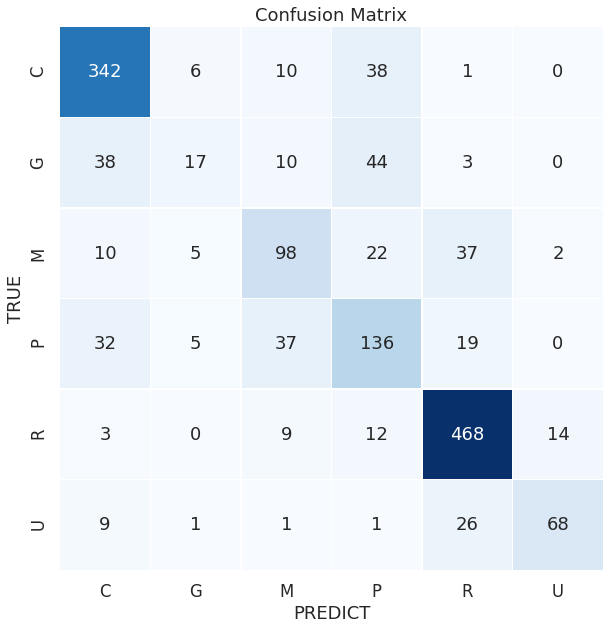

In [ ]:
# 混淆矩阵
cm = result[2]
classes = ['C', 'G', 'M', 'P', 'R', 'U']
_, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, xticklabels=classes, yticklabels=classes, fmt='.20g', square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title('Confusion Matrix')
ax.set_xlabel('PREDICT')
ax.set_ylabel('TRUE')

# 对比分析

In [ ]:
data = {'features': [], 'measurement': [], 'value': []}
measurement = ['C', 'G', 'M', 'P', 'R', 'U', 'Avg']
for _ in tqdm(range(20)):
  result = train_multi_gcn([graph_traffic_lp, graph_spatial_lp, graph_ts_lp], labels, layer_sizes=[64, 64], dropout=.3, lr=0.002, l2_reg=0.0001, verbose=0)
  data['features'] += ['land_cover_poi'] * 7
  data['measurement'] += measurement
  data['value'] += [result[1].loc['f1-score',][i] for i in range(7)]
for _ in tqdm(range(20)):
  result = train_multi_gcn([graph_traffic_l, graph_spatial_l, graph_ts_l], labels, layer_sizes=[64, 64], dropout=.3, lr=0.002, l2_reg=0.0001, verbose=0)
  data['features'] += ['land_cover'] * 7
  data['measurement'] += measurement
  data['value'] += [result[1].loc['f1-score',][i] for i in range(7)]
for _ in tqdm(range(20)):
  result = train_multi_gcn([graph_traffic_p, graph_spatial_p, graph_ts_p], labels, layer_sizes=[64, 64], dropout=.3, lr=0.002, l2_reg=0.0001, verbose=0)
  data['features'] += ['poi'] * 7
  data['measurement'] += measurement
  data['value'] += [result[1].loc['f1-score',][i] for i in range(7)]
for _ in tqdm(range(20)):
  result = train_multi_gcn([graph_traffic_n, graph_spatial_n, graph_ts_n], labels, layer_sizes=[64, 64], dropout=.3, lr=0.002, l2_reg=0.0001, verbose=0)
  data['features'] += ['one_hot'] * 7
  data['measurement'] += measurement
  data['value'] += [result[1].loc['f1-score',][i] for i in range(7)]

Text(0, 0.5, 'LAND USE')

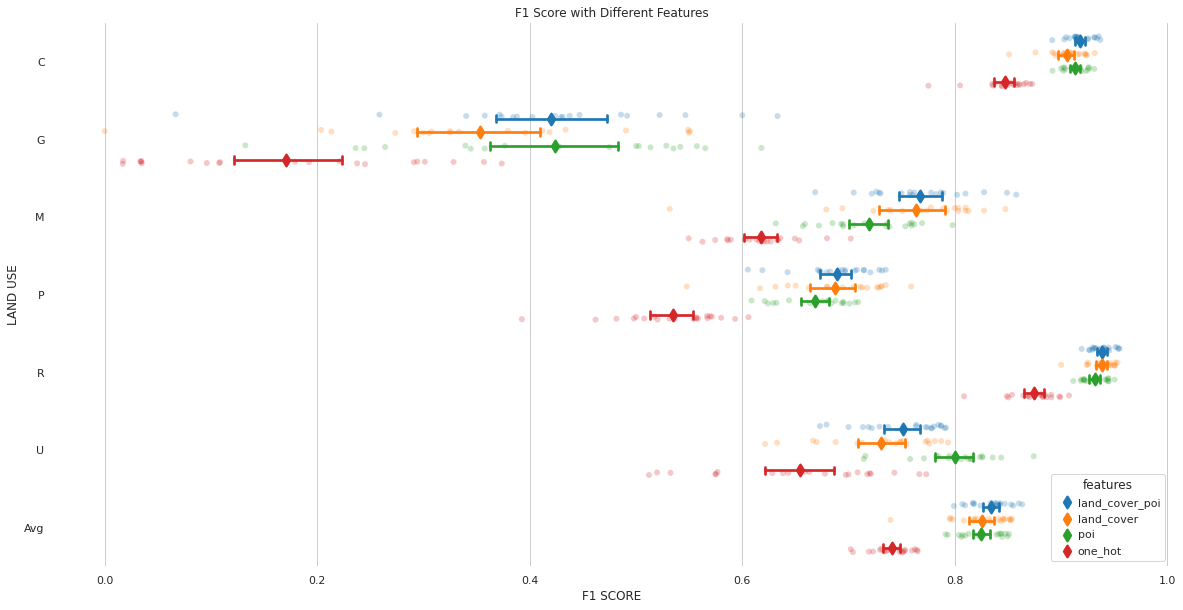

In [ ]:
data = pd.DataFrame(data)
sns.set(style="whitegrid")
# 移除坐标轴
f, ax = plt.subplots(figsize=(20, 10))
sns.despine(bottom=True, left=True)
# 绘制多类别散点图
sns.stripplot(x="value", y="measurement", hue="features", data=data, dodge=True, alpha=.25, zorder=1, palette=sns.color_palette("tab10"), size=6)
# 绘制均值中心点
sns.pointplot(x="value", y="measurement", hue="features", data=data, dodge=.532, join=False, palette=sns.color_palette("tab10"), markers="d", scale=1.2, capsize=.1, estimator=np.mean)
# 绘制图例
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[4:], label[4:], title='features', handletextpad=0, columnspacing=1, loc='lower right', ncol=1, frameon=True)
ax.set_title('F1 Score with Different Features')
ax.set_xlabel('F1 SCORE')
ax.set_ylabel('LAND USE') 